# Full machine learning project - House Price

In this project, I am going to present my skills in data analytics, feature engineering, feature selection and model evaluation. I am going to use the "House Price" dataset from kaggle.com, as it provides enough problems for me showcase my abilities of solving the issues. I am also going to create a full pipeline using open source libraries to tackle new data. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import scipy.stats as stats
import joblib
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from feature_engine.imputation import(
    AddMissingIndicator, 
    MeanMedianImputer, 
    CategoricalImputer
)
from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder
)
from feature_engine.transformation import(
    LogTransformer,
    YeoJohnsonTransformer
)
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper
import preprocessors as pp

pd.set_option('display.max_columns', None)

## 1.1 Data analytics

Let's explore the data!

In [2]:
# load dataset
df = pd.read_csv('train.csv')

# rows and columns of the data
print(df.shape)

# visualise the dataset
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Cast MSSubClass as object

df['MSSubClass'] = df['MSSubClass'].astype('O')

In [4]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Id', 'SalePrice'], axis=1), # predictive variables
    df['SalePrice'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

The house price dataset contains 1460 rows, that is, houses, and 80 columns, i.e., variables. 

79 are predictive variables and 1 is the target variable: SalePrice

## Analysis

**We will analyse the following:**

1. The target variable
2. Variable types (categorical and numerical)
3. Missing data
4. Numerical variables
    - Discrete
    - Continuous
    - Distributions
    - Transformations

5. Categorical variables
    - Cardinality
    - Rare Labels
    - Special mappings
    
6. Additional Reading Resources

## Target

Let's begin by exploring the target distribution.

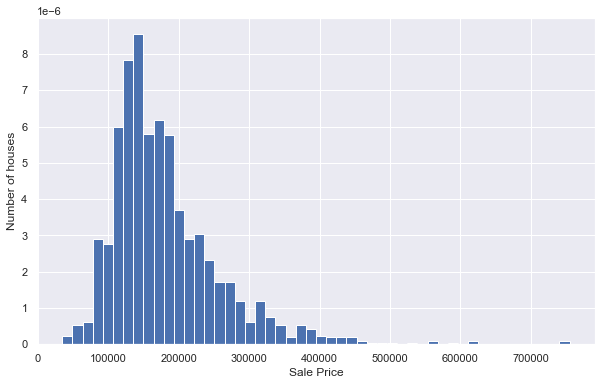

In [5]:
# histogran to evaluate target distribution

df['SalePrice'].hist(bins=50, density=True, figsize=(10,6))
plt.ylabel('Number of houses')
plt.xlabel('Sale Price')
plt.show()

We can see that the target is continuous, and the distribution is skewed towards the right.

We can improve the value spread with the log transformation.

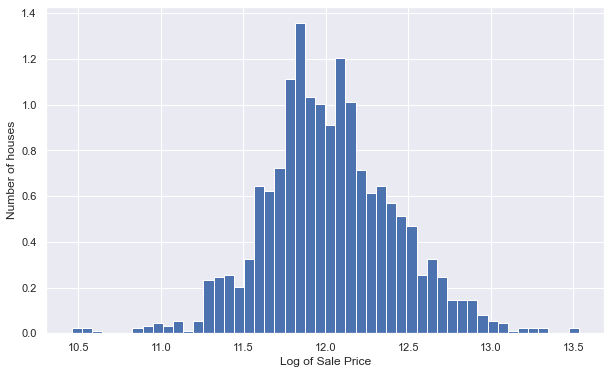

In [6]:
# let's transform the target using the logarithm

np.log(df['SalePrice']).hist(bins=50, density=True, figsize=(10,6))
plt.ylabel('Number of houses')
plt.xlabel('Log of Sale Price')
plt.show()

Looks better! Let's transform it!

In [7]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [8]:
# let's identify the categorical variables
# we will capture those of type *object*
# cast all variables as categorical

cat_vars = [var for var in df.columns if df[var].dtype == 'O']

# MSSubClass is also categorical by definition, despite its numeric values.

# lets add MSSubClass to the list of categorical variables
cat_vars = cat_vars + ['MSSubClass']

# number of categorical variables
len(cat_vars)

45

In [9]:
# make a list of the categorical variables that contain missing values

cat_vars_with_na = [
    var for var in cat_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[cat_vars_with_na].isnull().mean().sort_values(ascending=False)

PoolQC          0.995434
MiscFeature     0.961187
Alley           0.938356
Fence           0.814307
FireplaceQu     0.472603
GarageCond      0.056317
GarageQual      0.056317
GarageFinish    0.056317
GarageType      0.056317
BsmtFinType2    0.025114
BsmtExposure    0.025114
BsmtFinType1    0.024353
BsmtCond        0.024353
BsmtQual        0.024353
MasVnrType      0.004566
Electrical      0.000761
dtype: float64

Our dataset contains a few variables with a big proportion of missing values (4 variables at the top). And some other variables with a small percentage of missing observations.

This means that to train a machine learning model with this data set, we need to impute the missing data in these variables.

In [10]:
# variables to impute with the string missing
with_string_missing = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() > 0.1]

# variables to impute with the most frequent category
with_frequent_category = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() < 0.1]

In [11]:
# replace missing values with new label: "Missing"

# set up the class
cat_imputer_missing = CategoricalImputer(
    imputation_method='missing', variables=with_string_missing)

# fit the class to the train set
cat_imputer_missing.fit(X_train)

# the class learns and stores the parameters
cat_imputer_missing.imputer_dict_

{'Alley': 'Missing',
 'FireplaceQu': 'Missing',
 'PoolQC': 'Missing',
 'Fence': 'Missing',
 'MiscFeature': 'Missing'}

In [12]:
# replace NA by missing

# IMPORTANT: note that we could store this class with joblib
X_train = cat_imputer_missing.transform(X_train)
X_test = cat_imputer_missing.transform(X_test)

In [13]:
# replace missing values with most frequent category

# set up the class
cat_imputer_frequent = CategoricalImputer(
    imputation_method='frequent', variables=with_frequent_category)

# fit the class to the train set
cat_imputer_frequent.fit(X_train)

# the class learns and stores the parameters
cat_imputer_frequent.imputer_dict_

{'MasVnrType': 'None',
 'BsmtQual': 'TA',
 'BsmtCond': 'TA',
 'BsmtExposure': 'No',
 'BsmtFinType1': 'Unf',
 'BsmtFinType2': 'Unf',
 'Electrical': 'SBrkr',
 'GarageType': 'Attchd',
 'GarageFinish': 'Unf',
 'GarageQual': 'TA',
 'GarageCond': 'TA'}

In [14]:
# replace NA by frequent

X_train = cat_imputer_frequent.transform(X_train)
X_test = cat_imputer_frequent.transform(X_test)

In [15]:
# check that we have no missing information in the engineered variables

X_train[cat_vars_with_na].isnull().sum()

Alley           0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

### Numerical variables

To engineer missing values in numerical variables, we will:

- add a binary missing indicator variable
- and then replace the missing values in the original variable with the mean

In [16]:
# now let's identify the numerical variables

num_vars = [
    var for var in X_train.columns if var not in cat_vars and var != 'SalePrice'
]

# number of numerical variables
len(num_vars)

35

In [17]:
# make a list with the numerical variables that contain missing values
vars_with_na = [
    var for var in num_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

LotFrontage    0.177321
MasVnrArea     0.004566
GarageYrBlt    0.056317
dtype: float64

In [18]:
# print, makes my life easier when I want to create the config
vars_with_na

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [19]:
# add missing indicator

missing_ind = AddMissingIndicator(variables=vars_with_na)

missing_ind.fit(X_train)

X_train = missing_ind.transform(X_train)
X_test = missing_ind.transform(X_test)

# check the binary missing indicator variables
X_train[['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']].head()

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
930,0,0,0
656,0,0,0
45,0,0,0
1348,1,0,0
55,0,0,0


In [20]:
# then replace missing data with the mean

# set the imputer
mean_imputer = MeanMedianImputer(
    imputation_method='mean', variables=vars_with_na)

# learn and store parameters from train set
mean_imputer.fit(X_train)

# the stored parameters
mean_imputer.imputer_dict_

{'LotFrontage': 69.87974098057354,
 'MasVnrArea': 103.7974006116208,
 'GarageYrBlt': 1978.2959677419356}

In [21]:
X_train = mean_imputer.transform(X_train)
X_test = mean_imputer.transform(X_test)

# IMPORTANT: note that we could save the imputers with joblib

# check that we have no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [22]:
# check that test set does not contain null values in the engineered variables

[var for var in vars_with_na if X_test[var].isnull().sum() > 0]

[]

### Time and date

 Temporal variables

 Capture elapsed time

In [23]:
print('Number of numerical variables: ', len(num_vars))

# visualise the numerical variables
df[num_vars].head()

Number of numerical variables:  35


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008


We have 4 year variables in the dataset:

- YearBuilt: year in which the house was built
- YearRemodAdd: year in which the house was remodeled
- GarageYrBlt: year in which a garage was built
- YrSold: year in which the house was sold

We generally don't use date variables in their raw format. Instead, we extract information from them. For example, we can capture the difference in years between the year the house was built and the year the house was sold.

In [24]:
# list of variables that contain year information

year_vars = [var for var in num_vars if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [25]:
def elapsed_years(df, var):
    # capture difference between the year variable
    # and the year in which the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [26]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [27]:
# # now we drop YrSold
# drop_features = DropFeatures(features_to_drop=['YrSold'])

# X_train = drop_features.fit_transform(X_train)
# X_test = drop_features.transform(X_test)

## Discrete variables

Let's go ahead and find which variables are discrete, i.e., show a finite number of values

In [28]:
#  let's male a list of discrete variables
discrete_vars = [var for var in num_vars if len(
    df[var].unique()) < 20 and var not in year_vars]


print('Number of discrete variables: ', len(discrete_vars))

Number of discrete variables:  13


In [29]:
# let's visualise the discrete variables

df[discrete_vars].head()

,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,PoolArea,MoSold
0,7,5,1,0,2,1,3,1,8,0,2,0,2
1,6,8,0,1,2,0,3,1,6,1,2,0,5
2,7,5,1,0,2,1,3,1,6,1,2,0,9
3,7,5,1,0,1,0,3,1,7,1,3,0,2
4,8,5,1,0,2,1,4,1,9,1,3,0,12


These discrete variables tend to be qualifications (Qual) or grading scales (Cond), or refer to the number of rooms, or units (FullBath, GarageCars), or indicate the area of the room (KitchenAbvGr).

We expect higher prices, with bigger numbers.

Let's go ahead and analyse their contribution to the house price.

MoSold is the month in which the house was sold.

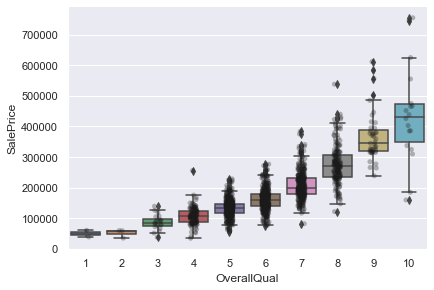

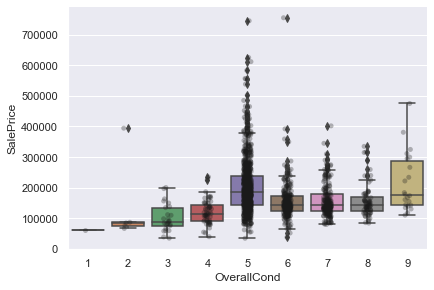

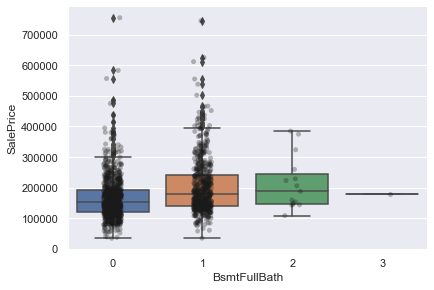

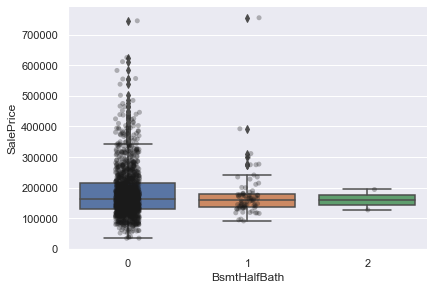

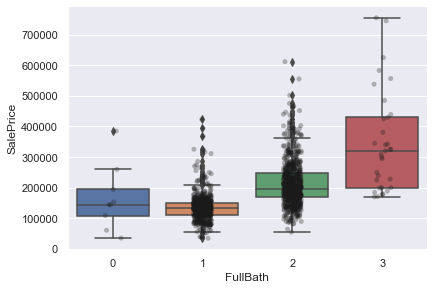

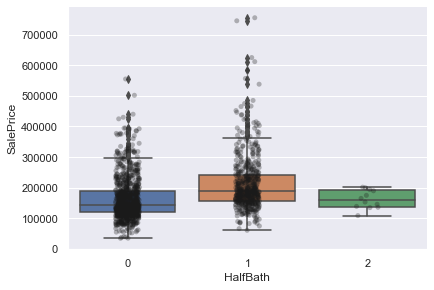

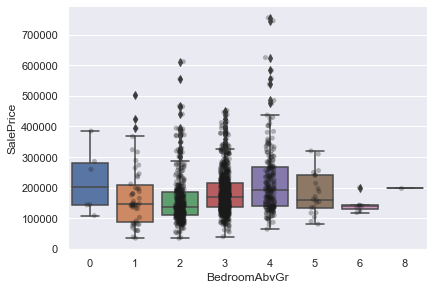

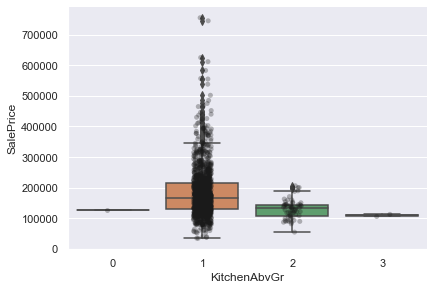

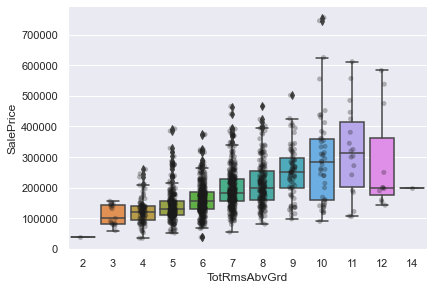

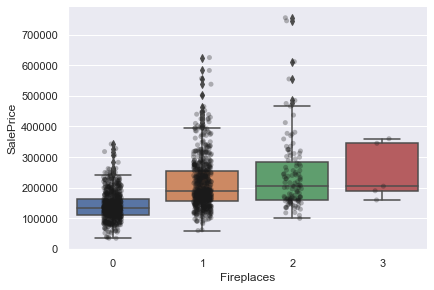

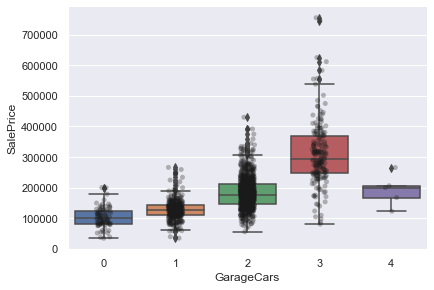

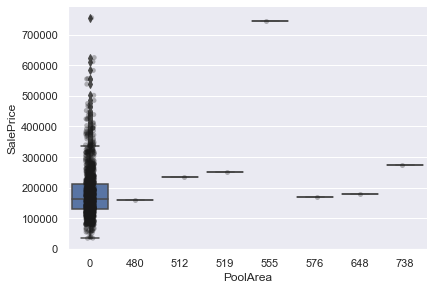

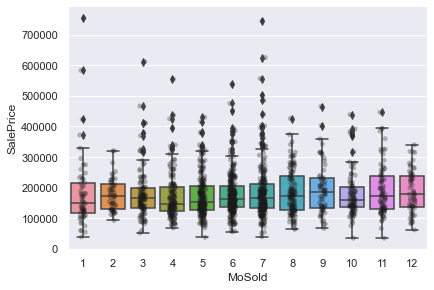

In [30]:
for var in discrete_vars:
    # make boxplot with Catplot
    sns.catplot(x=var, y='SalePrice', data=df, kind="box", height=4, aspect=1.5)
    # add data points to boxplot with stripplot
    sns.stripplot(x=var, y='SalePrice', data=df, jitter=0.1, alpha=0.3, color='k')
    plt.show()

For most discrete numerical variables, we see an increase in the sale price, with the quality, or overall condition, or  number of rooms, or surface.

For some variables, we don't see this tendency. Most likely that variable is not a good predictor of sale price.

## Continuous variables

Let's go ahead and find the distribution of the continuous variables. We will consider continuous variables to all those that are not temporal or discrete.

In [31]:
# make list of continuous variables
cont_vars = [
    var for var in num_vars if var not in discrete_vars+year_vars]

print('Number of continuous variables: ', len(cont_vars))

Number of continuous variables:  18


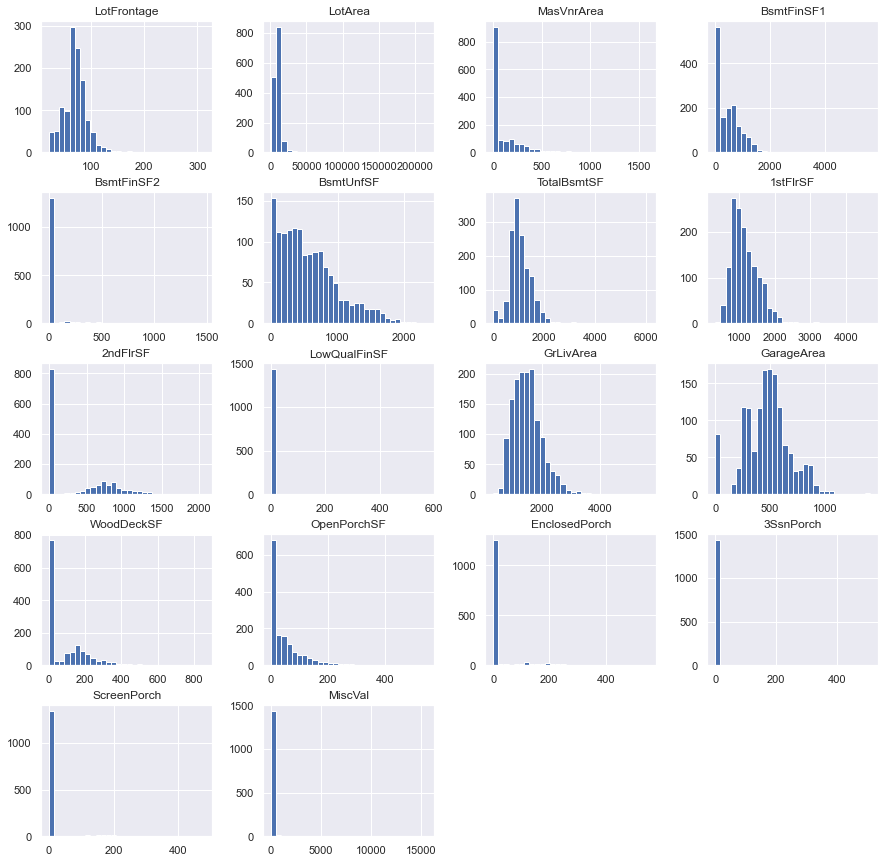

In [32]:
# lets plot histograms for all continuous variables

df[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

The variables are not normally distributed. And there are a particular few that are extremely skewed like 3SsnPorch, ScreenPorch and MiscVal.

Sometimes, transforming the variables to improve the value spread, improves the model performance. But it is unlikely that a transformation will help change the distribution of the super skewed variables dramatically.

We can apply a Yeo-Johnson transformation to variables like LotFrontage, LotArea, BsmUnfSF, and a binary transformation to variables like 3SsnPorch, ScreenPorch and MiscVal.

Let's go ahead and do that.

In [33]:
# first make a list with the super skewed variables for later.
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

# capture the remaining continuous variables.
cont_vars = [
    'LotFrontage',
    'LotArea',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
]

### Yeo-Johnson transformation

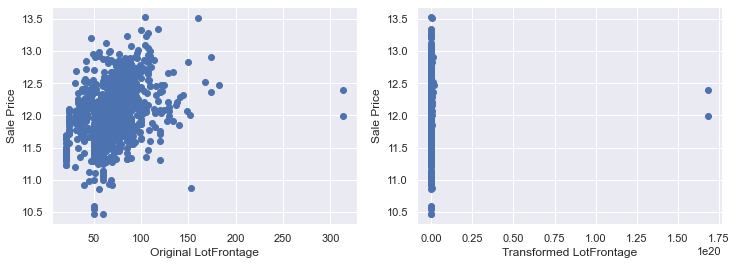

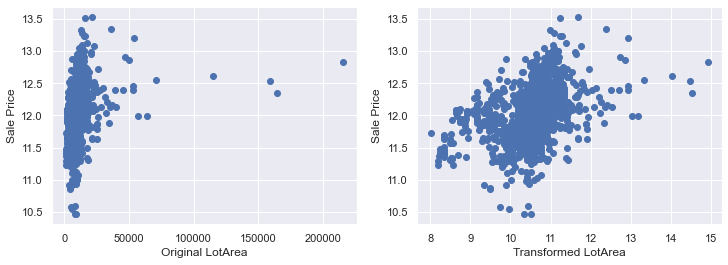

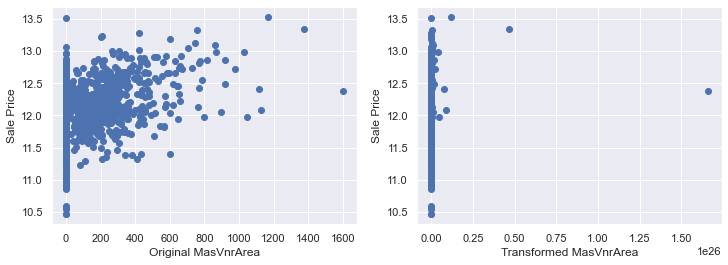

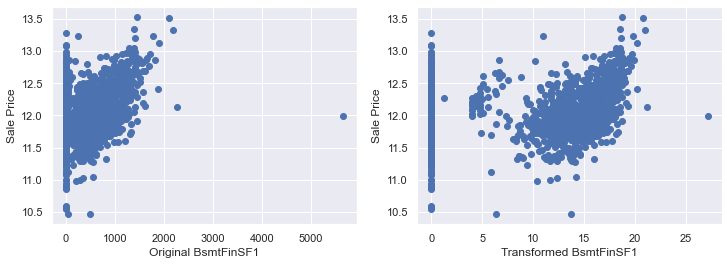

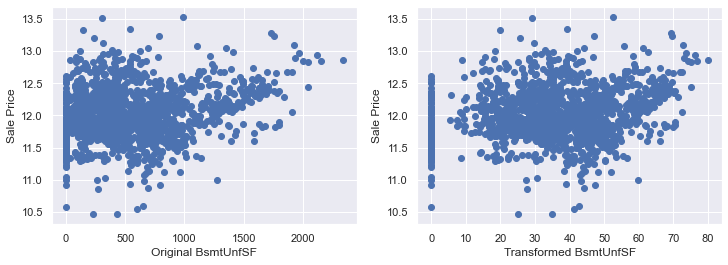

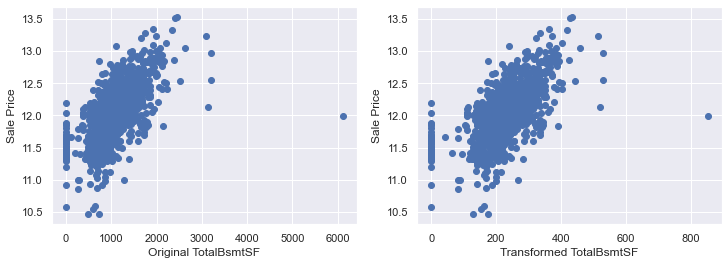

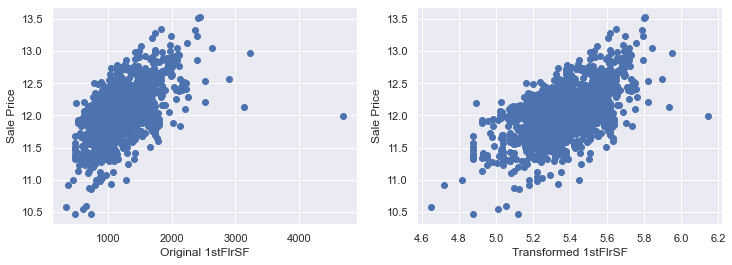

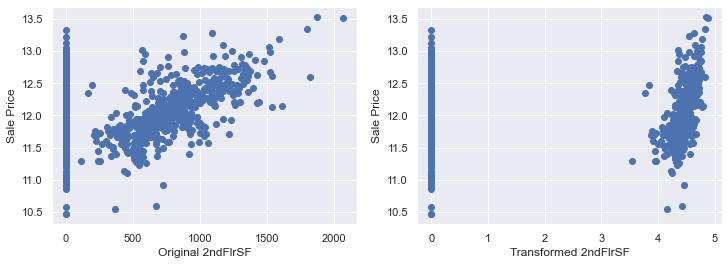

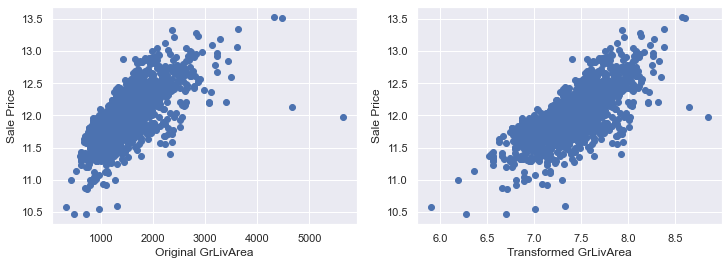

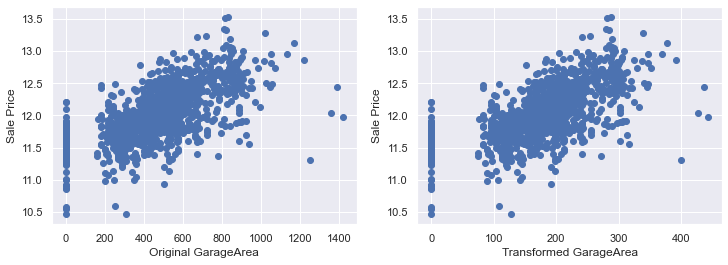

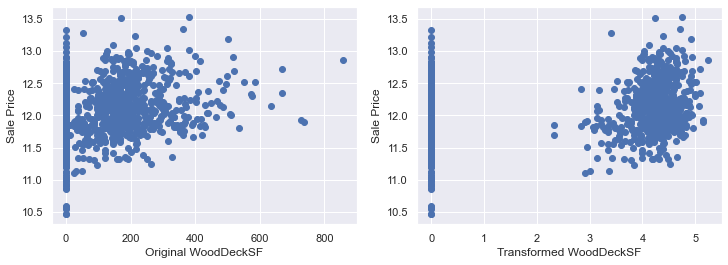

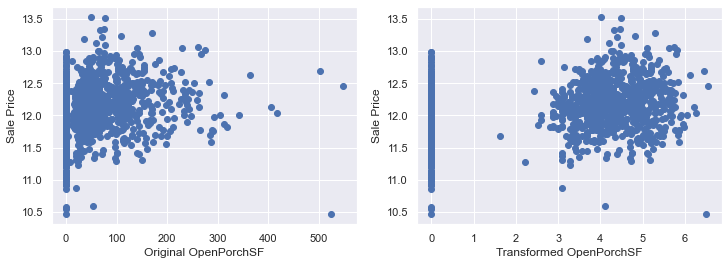

In [34]:
# Let's go ahead and analyse the distributions of the variables after applying a yeo-johnson transformation

# temporary copy of the data
tmp = df.copy()

for var in cont_vars:
    # transform the variable - yeo-johsnon
    tmp[var], param = stats.yeojohnson(df[var])

    
# let's plot the original or transformed variables vs sale price, and see if there is a relationship
for var in cont_vars:
    
    plt.figure(figsize=(12,4))
    
    # plot the original variable vs sale price    
    plt.subplot(1, 2, 1)
    plt.scatter(df[var], np.log(df['SalePrice']))
    plt.ylabel('Sale Price')
    plt.xlabel('Original ' + var)

    # plot transformed variable vs sale price
    plt.subplot(1, 2, 2)
    plt.scatter(tmp[var], np.log(tmp['SalePrice']))
    plt.ylabel('Sale Price')
    plt.xlabel('Transformed ' + var)
                
    plt.show()

By eye, the transformations seems to improve the relationship only for LotArea. Let's go ahead and transform that.

In [35]:
yeo_transformer = YeoJohnsonTransformer(
    variables=['LotArea'])

X_train = yeo_transformer.fit_transform(X_train)
X_test = yeo_transformer.transform(X_test)

# the learned parameter
yeo_transformer.lambda_dict_

C:\Users\simen\anaconda3\lib\site-packages\scipy\stats\morestats.py:1476: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
C:\Users\simen\anaconda3\lib\site-packages\scipy\optimize\optimize.py:2522: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\simen\anaconda3\lib\site-packages\scipy\optimize\optimize.py:2115: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\simen\anaconda3\lib\site-packages\scipy\optimize\optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


{'LotArea': -12.55283001172003}

In [36]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [37]:
# check absence of na in the test set
[var for var in X_train.columns if X_test[var].isnull().sum() > 0]

[]

### Logarithmic transformation

Now, let's do the same for the log transformation.

Let's try a different transformation now. Most variables contain the value 0, and thus we can't apply the logarithmic transformation, but we can certainly do that for the following variables:

 ["LotFrontage", "1stFlrSF", "GrLivArea"]
 
 So let's do that and see if that changes the variable distribution and its relationship with the target.

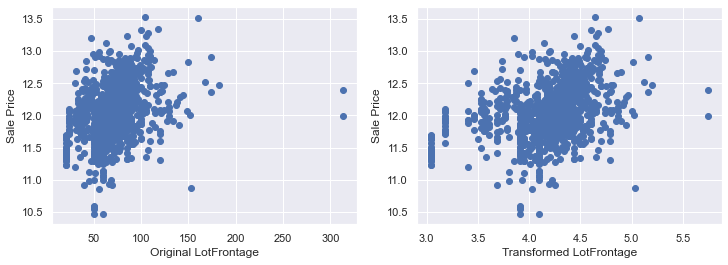

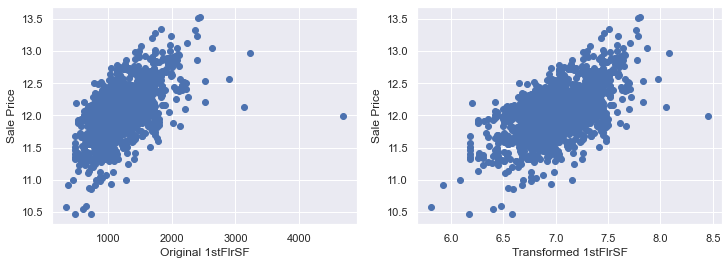

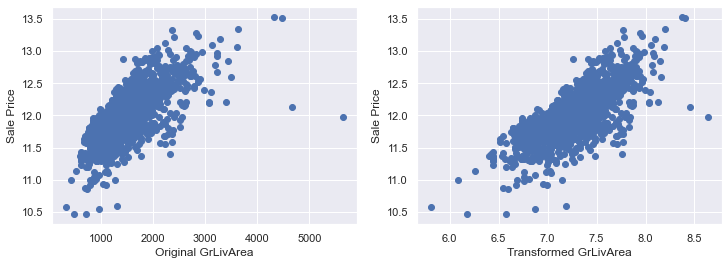

In [38]:
# Let's go ahead and analyse the distributions of these variables after applying a logarithmic transformation

tmp = df.copy()

for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    # transform the variable with logarithm
    tmp[var] = np.log(df[var])
    
# let's plot the original or transformed variables vs sale price, and see if there is a relationship
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    
    plt.figure(figsize=(12,4))
    
    # plot the original variable vs sale price    
    plt.subplot(1, 2, 1)
    plt.scatter(df[var], np.log(df['SalePrice']))
    plt.ylabel('Sale Price')
    plt.xlabel('Original ' + var)

    # plot transformed variable vs sale price
    plt.subplot(1, 2, 2)
    plt.scatter(tmp[var], np.log(tmp['SalePrice']))
    plt.ylabel('Sale Price')
    plt.xlabel('Transformed ' + var)
                
    plt.show()


The transformed variables have a better spread of the values, which may in turn, help make better predictions.

Let's transform them

In [39]:
log_transformer = LogTransformer(
    variables=["LotFrontage", "1stFlrSF", "GrLivArea"])

X_train = log_transformer.fit_transform(X_train)
X_test = log_transformer.transform(X_test)

In [40]:
# check that test set does not contain null values in the engineered variables
[var for var in ["LotFrontage", "1stFlrSF", "GrLivArea"] if X_test[var].isnull().sum() > 0]

[]

In [41]:
# same for train set
[var for var in ["LotFrontage", "1stFlrSF", "GrLivArea"] if X_train[var].isnull().sum() > 0]

[]

### Binarize skewed variables

There were a few variables very skewed, we would transform those into binary variables.

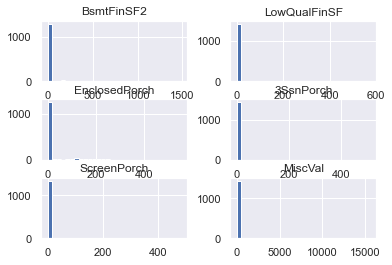

In [42]:
# Histograms for the skewed variables

df[skewed].hist(bins=30)
plt.show()

We would transform those into binary variables.

In [43]:
binarizer = SklearnTransformerWrapper(
    transformer=Binarizer(threshold=0), variables=skewed
)


X_train = binarizer.fit_transform(X_train)
X_test = binarizer.transform(X_test)

X_train[skewed].head()

,BsmtFinSF2,LowQualFinSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
930,0,0,0,0,0,0
656,0,0,0,0,0,0
45,0,0,0,0,0,0
1348,0,0,0,0,0,0
55,0,0,0,1,0,0


## Categorical variables

### Apply mappings

These are variables which values have an assigned order, related to quality. For more information, check Kaggle website.

In [44]:
# re-map strings to numbers, which determine quality

qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]

for var in qual_vars:
    X_train[var] = X_train[var].map(qual_mappings)
    X_test[var] = X_test[var].map(qual_mappings)

###############

exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'

X_train[var] = X_train[var].map(exposure_mappings)
X_test[var] = X_test[var].map(exposure_mappings)

###############

finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    X_train[var] = X_train[var].map(finish_mappings)
    X_test[var] = X_test[var].map(finish_mappings)

##############

garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

X_train[var] = X_train[var].map(garage_mappings)
X_test[var] = X_test[var].map(garage_mappings)

##############

fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

X_train[var] = X_train[var].map(fence_mappings)
X_test[var] = X_test[var].map(fence_mappings)

##############

# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

### Removing Rare Labels

For the remaining categorical variables, we will group those categories that are present in less than 1% of the observations. That is, all values of categorical variables that are shared by less than 1% of houses, well be replaced by the string "Rare".

In [45]:
# capture all quality variables

qual_vars  = qual_vars + finish_vars + ['BsmtExposure','GarageFinish','Fence']

# capture the remaining categorical variables
# (those that we did not re-map)

cat_others = [
    var for var in cat_vars if var not in qual_vars
]

len(cat_others)

31

In [46]:
rare_encoder = RareLabelEncoder(tol=0.01, n_categories=1, variables=cat_others)

# find common labels
rare_encoder.fit(X_train)

# the common labels are stored, we can save the class
# and then use it later :)
rare_encoder.encoder_dict_

{'MSSubClass': Int64Index([20, 60, 50, 120, 30, 160, 70, 80, 90, 190, 75, 85], dtype='int64'),
 'MSZoning': Index(['RL', 'RM', 'FV', 'RH'], dtype='object'),
 'Street': Index(['Pave'], dtype='object'),
 'Alley': Index(['Missing', 'Grvl', 'Pave'], dtype='object'),
 'LotShape': Index(['Reg', 'IR1', 'IR2'], dtype='object'),
 'LandContour': Index(['Lvl', 'Bnk', 'HLS', 'Low'], dtype='object'),
 'Utilities': Index(['AllPub'], dtype='object'),
 'LotConfig': Index(['Inside', 'Corner', 'CulDSac', 'FR2'], dtype='object'),
 'LandSlope': Index(['Gtl', 'Mod'], dtype='object'),
 'Neighborhood': Index(['NAmes', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'NridgHt',
        'Gilbert', 'Sawyer', 'NWAmes', 'BrkSide', 'SawyerW', 'Mitchel',
        'Crawfor', 'Timber', 'NoRidge', 'IDOTRR', 'ClearCr', 'SWISU', 'StoneBr',
        'Blmngtn', 'MeadowV', 'BrDale'],
       dtype='object'),
 'Condition1': Index(['Norm', 'Feedr', 'Artery', 'RRAn', 'PosN'], dtype='object'),
 'Condition2': Index(['Norm'], dtype='obj

In [47]:
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

### Encoding of categorical variables

Next, we need to transform the strings of the categorical variables into numbers. 

We will do it so that we capture the monotonic relationship between the label and the target.

In [48]:
# set up the encoder
cat_encoder = OrdinalEncoder(encoding_method='ordered', variables=cat_others)

# create the mappings
cat_encoder.fit(X_train, y_train)

# mappings are stored and class can be saved
cat_encoder.encoder_dict_

{'MSSubClass': {30: 0,
  'Rare': 1,
  190: 2,
  90: 3,
  160: 4,
  50: 5,
  85: 6,
  70: 7,
  80: 8,
  20: 9,
  75: 10,
  120: 11,
  60: 12},
 'MSZoning': {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4},
 'Street': {'Rare': 0, 'Pave': 1},
 'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
 'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
 'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
 'Utilities': {'Rare': 0, 'AllPub': 1},
 'LotConfig': {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4},
 'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
 'Neighborhood': {'IDOTRR': 0,
  'MeadowV': 1,
  'BrDale': 2,
  'Edwards': 3,
  'BrkSide': 4,
  'OldTown': 5,
  'Sawyer': 6,
  'SWISU': 7,
  'NAmes': 8,
  'Mitchel': 9,
  'SawyerW': 10,
  'Rare': 11,
  'NWAmes': 12,
  'Gilbert': 13,
  'Blmngtn': 14,
  'CollgCr': 15,
  'Crawfor': 16,
  'ClearCr': 17,
  'Somerst': 18,
  'Timber': 19,
  'StoneBr': 20,
  'NridgHt': 21,
  'NoRidge': 22},
 'Condition1': {'Artery': 0,
  'Feedr': 1,
  'Nor

In [49]:
X_train = cat_encoder.transform(X_train)
X_test = cat_encoder.transform(X_test)

In [50]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [51]:
# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

## Feature Scaling

For use in linear models, features need to be either scaled. We will scale features to the minimum and maximum values:

In [52]:
# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set

# sklearn returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

In [53]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.750000,0.75,0.461171,0.0,1.0,1.0,0.333333,1.000000,1.0,0.0,0.0,0.863636,0.4,1.0,0.75,0.6,0.777778,0.50,0.014706,0.049180,0.0,0.0,1.0,1.0,0.333333,0.00000,0.666667,0.5,1.0,0.666667,0.666667,0.666667,1.0,0.002835,0.0,0.0,0.673479,0.239935,1.0,1.00,1.0,1.0,0.559760,0.0,0.0,0.523250,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.416667,1.0,0.000000,0.0,0.75,0.018692,1.0,0.75,0.430183,0.5,0.5,1.0,0.116686,0.032907,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.545455,0.75,0.666667,0.75,0.0,0.0,0.0
1,0.750000,0.75,0.456066,0.0,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.363636,0.4,1.0,0.75,0.6,0.444444,0.75,0.360294,0.049180,0.0,0.0,0.6,0.6,0.666667,0.03375,0.666667,0.5,0.5,0.333333,0.666667,0.000000,0.8,0.142807,0.0,0.0,0.114724,0.172340,1.0,1.00,1.0,1.0,0.434539,0.0,0.0,0.406196,0.333333,0.0,0.333333,0.5,0.375,0.333333,0.666667,0.250000,1.0,0.000000,0.0,0.75,0.457944,0.5,0.25,0.220028,0.5,0.5,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.75,1.0,0.0,0.636364,0.50,0.666667,0.75,0.0,0.0,0.0
2,0.916667,0.75,0.394699,0.0,1.0,1.0,0.000000,0.333333,1.0,0.0,0.0,0.954545,0.4,1.0,1.00,0.6,0.888889,0.50,0.036765,0.098361,1.0,0.0,0.3,0.2,0.666667,0.25750,1.000000,0.5,1.0,1.000000,0.666667,0.000000,1.0,0.080794,0.0,0.0,0.601951,0.286743,1.0,1.00,1.0,1.0,0.627205,0.0,0.0,0.586296,0.333333,0.0,0.666667,0.0,0.250,0.333333,1.000000,0.333333,1.0,0.333333,0.8,0.75,0.046729,0.5,0.50,0.406206,0.5,0.5,1.0,0.228705,0.149909,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.090909,1.00,0.666667,0.75,0.0,0.0,0.0
3,0.750000,0.75,0.445002,0.0,1.0,1.0,0.666667,0.666667,1.0,0.0,0.0,0.454545,0.4,1.0,0.75,0.6,0.666667,0.50,0.066176,0.163934,0.0,0.0,1.0,1.0,0.333333,0.00000,0.666667,0.5,1.0,0.666667,0.666667,1.000000,1.0,0.255670,0.0,0.0,0.018114,0.242553,1.0,1.00,1.0,1.0,0.566920,0.0,0.0,0.529943,0.333333,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.250000,1.0,0.333333,0.4,0.75,0.084112,0.5,0.50,0.362482,0.5,0.5,1.0,0.469078,0.045704,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.636364,0.25,0.666667,0.75,1.0,0.0,0.0
4,0.750000,0.75,0.577658,0.0,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.363636,0.4,1.0,0.75,0.6,0.555556,0.50,0.323529,0.737705,0.0,0.0,0.6,0.7,0.666667,0.17000,0.333333,0.5,0.5,0.333333,0.666667,0.000000,0.6,0.086818,0.0,0.0,0.434278,0.233224,1.0,0.75,1.0,1.0,0.549026,0.0,0.0,0.513216,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.333333,0.416667,1.0,0.333333,0.8,0.75,0.411215,0.5,0.50,0.406206,0.5,0.5,1.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.00,1.0,0.0,0.545455,0.50,0.666667,0.75,0.0,0.0,0.0


### Feature Selection

Let's go ahead and select a subset of the most predictive features. There is an element of randomness in the Lasso regression, so remember to set the seed.

In [54]:
# We will do the model fitting and feature selection
# altogether in a few lines of code

# first, we specify the Lasso Regression model, and we
# select a suitable alpha (equivalent of penalty).
# The bigger the alpha the less features that will be selected.

# Then we use the selectFromModel object from sklearn, which
# will select automatically the features which coefficients are non-zero

# remember to set the seed, the random state in this function
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=0))

# train Lasso model and select features
sel_.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.001, random_state=0))

In [55]:
sel_.get_support().sum()

37

In [56]:
# let's print the number of total and selected features

# this is how we can make a list of the selected features
selected_feats = X_train.columns[(sel_.get_support())]

# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 82
selected features: 37
features with coefficients shrank to zero: 45


In [57]:
# print the selected features
features = selected_feats.to_list()

In [58]:
# reduce the train and test set to the selected features

X_train = X_train[features]
X_test = X_test[features]

### Regularised linear regression: Lasso

In [59]:
# set up the model
# remember to set the random_state / seed

lin_model = Lasso(alpha=0.001, random_state=0)

# train the model

lin_model.fit(X_train, y_train)

Lasso(alpha=0.001, random_state=0)

In [60]:
# evaluate the model:
# ====================

# remember that we log transformed the output (SalePrice)
# in our feature engineering notebook (step 2).

# In order to get the true performance of the Lasso
# we need to transform both the target and the predictions
# back to the original house prices values.

# We will evaluate performance using the mean squared error and
# the root of the mean squared error and r2

# make predictions for train set
pred = lin_model.predict(X_train)

# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# make predictions for test set
pred = lin_model.predict(X_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Average house price: ', int(np.exp(y_train).median()))

train mse: 781716437
train rmse: 27959
train r2: 0.874801811894568

test mse: 1060664856
test rmse: 32567
test r2: 0.8456567137542794

Average house price:  163000


Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

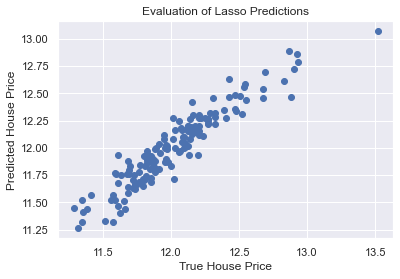

In [61]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, lin_model.predict(X_test))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Lasso Predictions')

We can see that our model is doing a pretty good job at estimating house prices.

In [62]:
y_test.reset_index(drop=True)

0      12.209188
1      11.798104
2      11.608236
3      12.165251
4      11.385092
         ...    
141    11.884489
142    12.287653
143    11.921718
144    11.598727
145    12.017331
Name: SalePrice, Length: 146, dtype: float64

In [63]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(lin_model.predict(X_test))

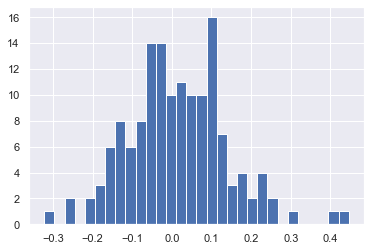

In [64]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

errors = y_test - preds
errors.hist(bins=30)
plt.show()

The distribution of the errors follows quite closely a gaussian distribution. That suggests that our model is doing a good job as well.

### Feature importance

Text(0.5, 1.0, 'Feature Importance')

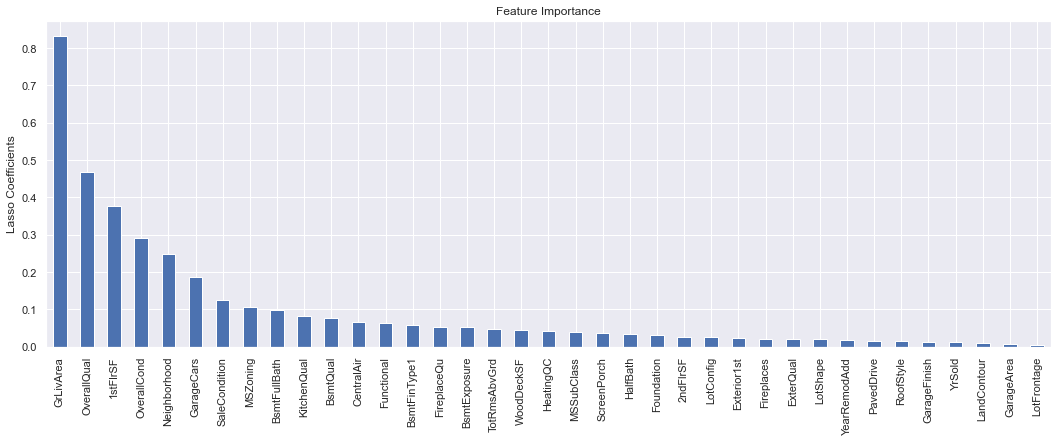

In [65]:
# Finally, just for fun, let's look at the feature importance

importance = pd.Series(np.abs(lin_model.coef_.ravel()))
importance.index = features
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')

## Pipeline for new data

### Configuration

In [71]:
# Import the data
df = pd.read_csv('train.csv')

# Cast MSSubClass as object
df['MSSubClass'] = df['MSSubClass'].astype('O')

#Let's seperate into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Id', 'SalePrice'], axis=1), # Dropping ID and the dependent variable.
    df['SalePrice'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

# Transform the target
y_train = np.log(y_train)
y_test = np.log(y_test)

In [72]:
# categorical variables with NA in train set
CATEGORICAL_VARS_WITH_NA_FREQUENT = ['BsmtQual', 'BsmtExposure',
                                     'BsmtFinType1', 'GarageFinish']


CATEGORICAL_VARS_WITH_NA_MISSING = ['FireplaceQu']


# numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = ['LotFrontage']


TEMPORAL_VARS = ['YearRemodAdd']
REF_VAR = "YrSold"

# this variable is to calculate the temporal variable,
# can be dropped afterwards
DROP_FEATURES = ["YrSold"]

# variables to log transform
NUMERICALS_LOG_VARS = ["LotFrontage", "1stFlrSF", "GrLivArea"]


# variables to binarize
BINARIZE_VARS = ['ScreenPorch']

# variables to map
QUAL_VARS = ['ExterQual', 'BsmtQual',
             'HeatingQC', 'KitchenQual', 'FireplaceQu']

EXPOSURE_VARS = ['BsmtExposure']

FINISH_VARS = ['BsmtFinType1']

GARAGE_VARS = ['GarageFinish']

FENCE_VARS = ['Fence']


# categorical variables to encode
CATEGORICAL_VARS = ['MSSubClass',  'MSZoning',  'LotShape',  'LandContour',
                    'LotConfig', 'Neighborhood', 'RoofStyle', 'Exterior1st',
                    'Foundation', 'CentralAir', 'Functional', 'PavedDrive',
                    'SaleCondition']


# variable mappings
QUAL_MAPPINGS = {'Po': 1, 'Fa': 2, 'TA': 3,
                 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

EXPOSURE_MAPPINGS = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

FINISH_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1,
                   'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

GARAGE_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}


# the selected variables
FEATURES = [
    'MSSubClass',
    'MSZoning',
    'LotFrontage',
    'LotShape',
    'LandContour',
    'LotConfig',
    'Neighborhood',
    'OverallQual',
    'OverallCond',
    'YearRemodAdd',
    'RoofStyle',
    'Exterior1st',
    'ExterQual',
    'Foundation',
    'BsmtQual',
    'BsmtExposure',
    'BsmtFinType1',
    'HeatingQC',
    'CentralAir',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'BsmtFullBath',
    'HalfBath',
    'KitchenQual',
    'TotRmsAbvGrd',
    'Functional',
    'Fireplaces',
    'FireplaceQu',
    'GarageFinish',
    'GarageCars',
    'GarageArea',
    'PavedDrive',
    'WoodDeckSF',
    'ScreenPorch',
    'SaleCondition',
    # this one is only to calculate temporal variable:
    "YrSold",
]

In [73]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

X_train.shape, X_test.shape

((1314, 37), (146, 37))

We have 3 steps less, they are commented out. So the pipeline is also simpler:

- the yeo-johnson transformation
- 1 of the mappings
- the selection procedure

this makes the pipeline faster and easier to deploy.

In [74]:
# set up the pipeline
price_pipe = Pipeline([

    # ===== IMPUTATION =====
    # impute categorical variables with string missing
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING)),

    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)),

    # add missing indicator
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),

    # impute numerical variables with the mean
    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA
    )),
    
    
    # == TEMPORAL VARIABLES ====
    ('elapsed_time', pp.TemporalVariableTransformer(
        variables=TEMPORAL_VARS, reference_variable=REF_VAR)),

    ('drop_features', DropFeatures(features_to_drop=[REF_VAR])),

   

    # ==== VARIABLE TRANSFORMATION =====
    ('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),
    
#     ('yeojohnson', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS)),
    
    ('binarizer', SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=BINARIZE_VARS)),
    

    # === mappers ===
    ('mapper_qual', pp.Mapper(
        variables=QUAL_VARS, mappings=QUAL_MAPPINGS)),

    ('mapper_exposure', pp.Mapper(
        variables=EXPOSURE_VARS, mappings=EXPOSURE_MAPPINGS)),

    ('mapper_finish', pp.Mapper(
        variables=FINISH_VARS, mappings=FINISH_MAPPINGS)),

    ('mapper_garage', pp.Mapper(
        variables=GARAGE_VARS, mappings=GARAGE_MAPPINGS)),
    
#     ('mapper_fence', pp.Mapper(
#         variables=FENCE_VARS, mappings=FENCE_MAPPINGS)),


    # == CATEGORICAL ENCODING
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.01, n_categories=1, variables=CATEGORICAL_VARS
    )),

    # encode categorical and discrete variables using the target mean
    ('categorical_encoder', OrdinalEncoder(
        encoding_method='ordered', variables=CATEGORICAL_VARS)),
    
    
    ('scaler', MinMaxScaler()),
#     ('selector', SelectFromModel(Lasso(alpha=0.001, random_state=0))),
    ('Lasso', Lasso(alpha=0.001, random_state=0)),
])

In [75]:
# train the pipeline
price_pipe.fit(X_train, y_train)

Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['FireplaceQu'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtQual', 'BsmtExposure',
                                               'BsmtFinType1',
                                               'GarageFinish'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['LotFrontage'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method=...
                                             'Foundation', 'CentralAir',
                                             'Functional', 'PavedDrive',
                                             'SaleCondition'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['MSSubClass', 'MSZoning', 'LotShape',
                                           'LandContour',

## Score new data

In [77]:
# load the unseen / new dataset
data = pd.read_csv('test.csv')

data.drop('Id', axis=1, inplace=True)

data['MSSubClass'] = data['MSSubClass'].astype('O')

data = data[FEATURES]

print(data.shape)

(1459, 37)


There are going to be a number of variables in this new dataset that got missing values that was not present in the train dataset. Let check that out

In [78]:
# New variables with missing data
new_vars_with_na = [
    var for var in FEATURES
    if var not in CATEGORICAL_VARS_WITH_NA_FREQUENT +
    CATEGORICAL_VARS_WITH_NA_MISSING +
    NUMERICAL_VARS_WITH_NA
    and data[var].isnull().sum() > 0]

new_vars_with_na

['MSZoning',
 'Exterior1st',
 'BsmtFullBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea']

The pipeline won't be able to score these oberservations, so we are just going to drop them.

In [79]:
data.dropna(subset=new_vars_with_na, inplace=True)

print(data.shape)

(1449, 37)


In [80]:
new_preds = price_pipe.predict(data)

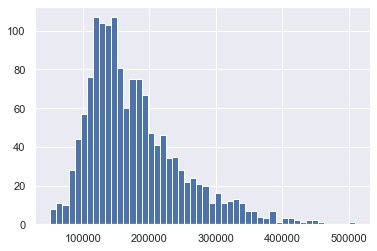

In [81]:
# Let's plot the predicted sale prices
pd.Series(np.exp(new_preds)).hist(bins=50)
plt.show()